In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.cuda.amp import GradScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from tqdm.auto import tqdm
from skimage.metrics import peak_signal_noise_ratio
import torchvision.models as models
from torch.nn.functional import mse_loss
from torch.optim import Adam
from sr_model import CNNSuperResolutionModel, FSRCNN
from IPython import display

In [2]:
hr_imgs = torch.load("hr_dataset.pt").cpu()
blur_imgs = torch.load("blur_dataset.pt").cpu()

print(hr_imgs.shape)
print(blur_imgs.shape)

hr_imgs = hr_imgs[:, ...].cuda()
blur_imgs = blur_imgs[:, ...].cuda()

torch.Size([9078, 3, 256, 256])
torch.Size([9078, 3, 128, 128])


In [3]:
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))

torch.cuda.memory_allocated: 8.311157GB


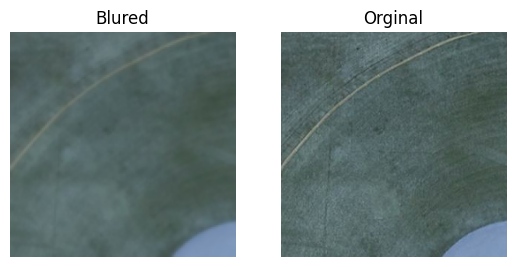

In [4]:
index = 2
plt.figure()
plt.subplot(121)
plt.imshow(blur_imgs[index, ...].permute(1,2,0).cpu().to(torch.float32))
plt.axis('off')
plt.title('Blured')
plt.subplot(122)
plt.imshow(hr_imgs[index, ...].permute(1,2,0).cpu().to(torch.float32))
plt.axis('off')
plt.title('Orginal')
plt.show()

In [5]:
train_valid_dataset = torch.utils.data.dataset.TensorDataset(blur_imgs,hr_imgs)
train_size = int(0.8*len(train_valid_dataset))
test_size = len(train_valid_dataset)-train_size
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(
    train_valid_dataset, [train_size, test_size]
)

Train Dataset length:  7262
Valid Dataset Length:  1816


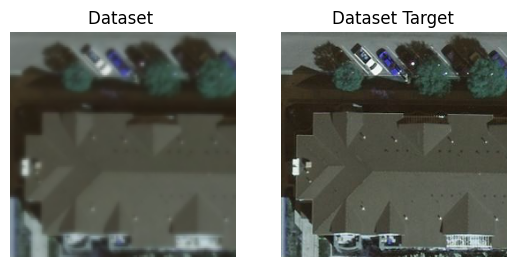

In [6]:
print('Train Dataset length: ', len(train_dataset))
print('Valid Dataset Length: ', len(valid_dataset))

looked_up = 5
plt.figure()
plt.subplot(121)
plt.imshow(valid_dataset.__getitem__(looked_up)[0].permute(1,2,0).cpu().to(torch.float32))
plt.axis('off')
plt.title('Dataset ')
plt.subplot(122)
plt.imshow(valid_dataset.__getitem__(looked_up)[1].permute(1,2,0).cpu().to(torch.float32))
plt.axis('off')
plt.title('Dataset Target')
plt.show()

In [7]:
def compute_normalization_parameters(dataset):
    mean_ = torch.zeros_like(dataset[0][0])
    std_ = torch.zeros_like(dataset[0][0])
    for img, _ in dataset:
        mean_ += img
    mean_ /= len(dataset)
    for img, _ in dataset:
        std_ += (mean_ - img) ** 2
    std_ /= len(dataset)
    std_ = torch.sqrt(std_)
    std_[std_ == 0] = 1


    mean_1 = torch.zeros_like(dataset[0][1])
    std_1 = torch.zeros_like(dataset[0][1])
    for _, img in dataset:
        mean_1 += img
    mean_1 /= len(dataset)
    for _, img in dataset:
        std_1 += (mean_1 - img) ** 2
    std_1 /= len(dataset)
    std_1 = torch.sqrt(std_1)
    std_1[std_1 == 0] = 1
    return mean_,std_,mean_1,std_1

In [8]:
class DatasetStandardization(torch.utils.data.Dataset):
    def __init__(self, base_dataset, transform, transform_target):
        self.base_dataset = base_dataset
        self.transform = transform
        self.transform_target = transform_target

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        return self.transform(img), self.transform_target(target)

    def __len__(self):
        return len(self.base_dataset)

mean_,std_,mean_1,std_1 = compute_normalization_parameters(train_dataset)
mean_2,std_2,mean_3,std_3 = compute_normalization_parameters(valid_dataset)
mean_4,std_4,mean_5,std_5 = compute_normalization_parameters(train_valid_dataset)

data_transforms_train = transforms.Compose(
    [transforms.Lambda(lambda x: (x-mean_)/std_)]
)

target_transform_train = transforms.Compose(
    [transforms.Lambda(lambda x: (x-mean_1)/std_1)]
)

data_transforms_valid = transforms.Compose(
    [transforms.Lambda(lambda x: (x-mean_2)/std_2)]
)

target_transform_valid = transforms.Compose(
    [transforms.Lambda(lambda x: (x-mean_3)/std_3)]
)

data_transforms_complete = transforms.Compose(
    [transforms.Lambda(lambda x: (x-mean_4)/std_4)]
)

target_transform_complete = transforms.Compose(
    [transforms.Lambda(lambda x: (x-mean_5)/std_5)]
)

class DatasetNormalization(torch.utils.data.Dataset):
    def __init__(self, base_dataset, transform, transform_target):
        self.base_dataset = base_dataset
        self.transform = transform
        self.transform_target = transform_target

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        return self.transform(img), self.transform_target(target)

    def __len__(self):
        return len(self.base_dataset)

data_transforms_train = transforms.Compose(
    [transforms.Lambda(lambda x: x/255)]
)

target_transform_train = transforms.Compose(
    [transforms.Lambda(lambda x: x/255)]
)

data_transforms_valid = transforms.Compose(
    [transforms.Lambda(lambda x: x/255)]
)

target_transform_valid = transforms.Compose(
    [transforms.Lambda(lambda x: x/255)]
)

data_transforms_complete = transforms.Compose(
    [transforms.Lambda(lambda x: x/255)]
)

target_transform_complete = transforms.Compose(
    [transforms.Lambda(lambda x: x/255)]
)

train_dataset = DatasetNormalization(train_dataset, data_transforms_train, target_transform_train)
valid_dataset = DatasetNormalization(valid_dataset, data_transforms_valid, target_transform_valid)

In [7]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

Train Dataset length:  7262
Valid Dataset Length:  1816


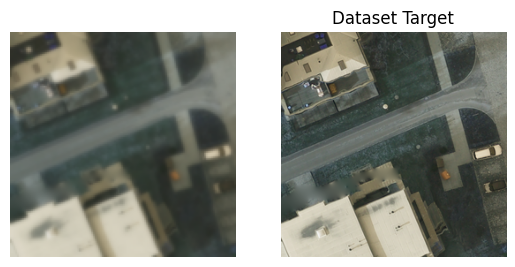

In [9]:
print('Train Dataset length: ', len(train_dataset))
print('Valid Dataset Length: ', len(valid_dataset))

true_np = valid_dataset.__getitem__(looked_up)[1]
blur_np = valid_dataset.__getitem__(looked_up)[0]

looked_up = 20
plt.figure()
plt.subplot(121)
plt.imshow(blur_np.permute(1,2,0).cpu().to(torch.float32))
plt.axis('off')
plt.subplot(122)
plt.imshow(true_np.permute(1,2,0).cpu().to(torch.float32))
plt.axis('off')
plt.title('Dataset Target')
plt.show()

In [10]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False
)

In [11]:
import torchvision.models as models

def single_to_three_channels(x):
    return x.repeat(1, 3, 1, 1)

class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        self.vgg = models.vgg16(pretrained=True).features[:8].cuda().eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        #x, y = single_to_three_channels(x), single_to_three_channels(y)
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = nn.functional.mse_loss(x_vgg, y_vgg) + nn.functional.mse_loss(x,y) # UPDATED LOSS
        return loss


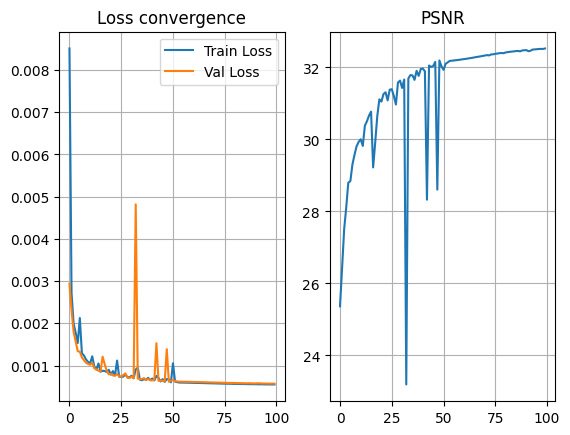

In [12]:
n_epochs = 100
learning_rate = 1e-3
upscale_factor = 2
model = FSRCNN(upscale_factor).cuda()
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameters: ', params)

best_accu = 1e6

loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

scaler = GradScaler()

train_set_len = len(train_loader)
val_set_len = len(valid_loader)
train_loss, val_loss, psnr_loss = [], [], []
plt.figure()

for epoch in tqdm(range(n_epochs), desc='Epoch', disable=False):
    model.train()
    accu = 0.0
    
    for X_, y_ in train_loader:
        # Forward pass
        y_hat = model(X_)
        
        loss = loss_fn(y_hat, y_)
        accu += loss.item()

        # backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        
        scaler.update()
        
    train_loss.append(accu / train_set_len)

    # Validation - no gradient & eval mode
    model.eval()
    accu = 0.0
    accu_psnr = 0.0
    with torch.no_grad():
        for X_, y_ in valid_loader:
            # Forward pass
            y_hat = model(X_)
            
            loss = loss_fn(y_hat, y_)
            accu += loss.item()
            accu_psnr += psnr(y_,y_hat)
        val_loss.append(accu / val_set_len)
        scheduler.step(accu/val_set_len)
        psnr_loss.append(accu_psnr / val_set_len)
        #print('Current PSNR: ',accu_psnr/val_set_len, 'dB')
        #print('Current val_loss: ', accu/val_set_len)
    if accu/train_set_len < best_accu:
        best_accu = accu/train_set_len
        torch.save(model.state_dict(), 'model.pt')
    plt.clf()
    plt.subplot(121)
    plt.plot(train_loss,label='Train Loss')
    plt.plot(val_loss,label='Val Loss')
    plt.grid()
    plt.legend()
    plt.title('Loss convergence')
    plt.subplot(122)
    plt.plot(psnr_loss)
    plt.grid()
    plt.title('PSNR')
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [ ]:
model = WaveMix(
                depth = 4,
                mult = 2,
                ff_channel = 64,
                final_dim = 64,
                dropout = 0.5,
                level=1,
                ).cuda()
model.load_state_dict(torch.load('model.pt'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


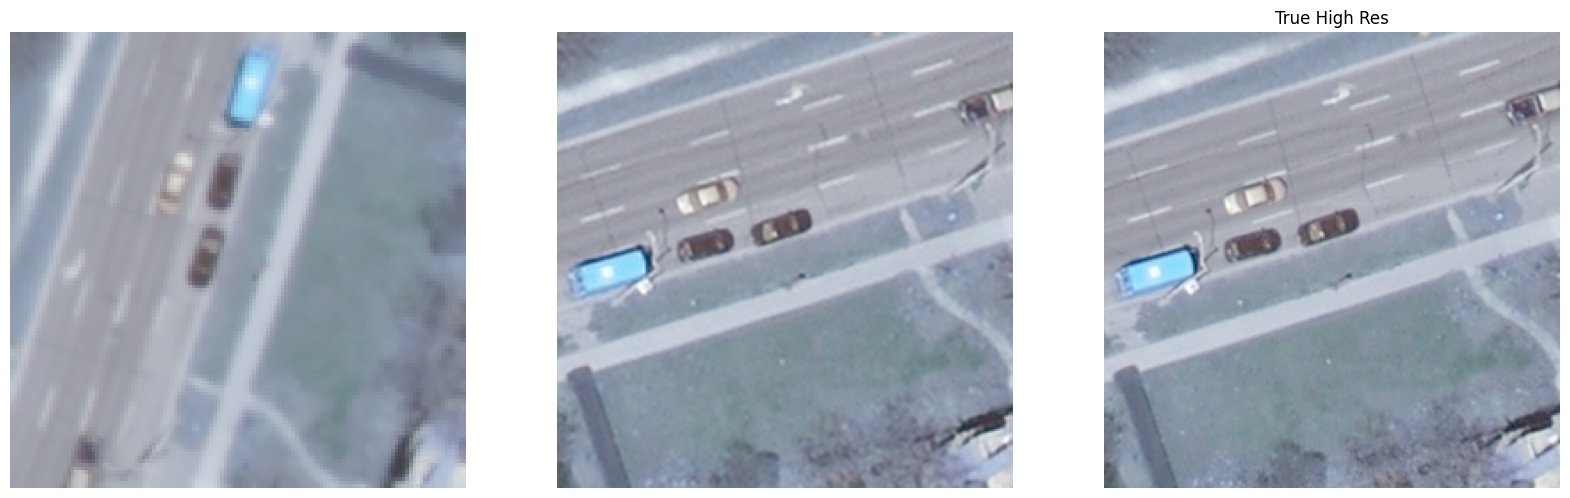

In [53]:
looked_up = 1800
with torch.no_grad():
    y_hat = model(valid_dataset.__getitem__(looked_up)[0].unsqueeze(0)).squeeze(0)
plt.figure(figsize=(20,20))
plt.subplot(131)
img_ori = valid_dataset.__getitem__(looked_up)[0]
img_true = valid_dataset.__getitem__(looked_up)[1]

plt.imshow(img_ori.cpu().permute(2,1,0).to(torch.float32))
plt.axis('off')
plt.subplot(132)
plt.imshow(y_hat.cpu().permute(1,2,0).to(torch.float32))
plt.axis('off')
plt.subplot(133)
plt.imshow(img_true.cpu().permute(1,2,0).to(torch.float32))
plt.axis('off')
plt.title('True High Res')
plt.savefig('mixed_result.png')
plt.show()